In [7]:
%matplotlib widget
from bmcs_cross_section.api import MKappa, EC2, ACI440, AnaFRPBending, ReinfLayer
import bmcs_utils.api as bu 
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bu.set_latex_mpl_format()
plot_colors = bu.plot_colors

In [64]:
def get_exp_data():
    delimiter=';'
    decimal=','
    file_path = './verification_data/FRP_data_for_Ana_model_validation.csv'
    df = pd.read_csv(file_path, 
                     delimiter=delimiter, 
                     decimal=decimal, 
                     encoding='latin-1', 
                     skiprows=[0, 2], 
                     skipfooter=3,
                     usecols=[1, 2, 3, 5, 6, 9, 10, 16, 17, 25, 26, 27, 28, 29, 30]
                    )
    
    for i in range(len(df.index)):
        b = df['b'][i]
        d = df['d_eqv'][i]
        f_cm = df['f_cm'][i]
        A_f = df['A_f_eqv'][i]
        E_f = df['E_f'][i]
        f_fu = df['f_fu'][i]
        Mu_test = df['test'][i]
        
        ana = AnaFRPBending(A_f=A_f, f_fu=f_fu, E_f=E_f, f_cm=f_cm, b=b, d=d)
        df.loc[i, 'M_u_aci'] = ACI440.get_M_n(A_f=A_f, f_fu=f_fu, E_f=E_f, f_c=f_cm, b=b, d=d)
        df.loc[i, 'M_u_sug'] = ana.M_u
        df.loc[i, r'ACI2/Test'] = np.round(df.loc[i, 'M_u_aci'] / Mu_test, 3)
        df.loc[i, r'Ana2/Test'] = np.round(df.loc[i, 'M_u_sug'] / Mu_test, 3)

        df.loc[i, r'rho_fb_aci'] = np.round(ACI440.get_rho_balanced(f_c=f_cm, f_fu=f_fu, E_f=E_f)*100, 2)
        df.loc[i, r'rho_fb_ana'] = np.round(ana.rho_fb*100, 2)
        
    
#     pd.DataFrame(data_new).to_csv('./verification_data/FRP_data_for_Ana_model_validation_calculated.csv', 
#                                   sep=delimiter, decimal=decimal, header=False, index=False)
    return df

df = get_exp_data()
# df.drop(columns=['Ana'])
df

C:\Users\hspartali\AppData\Local\Temp\ipykernel_24368\232961177.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path,


,Ref.,Beam,FRP 1 type,Failure mode,b,d_eqv,E_f,A_f_eqv,f_fu,f_cm,...,ACI,Ana,ACI/Test,Ana/Test,M_u_aci,M_u_sug,ACI2/Test,Ana2/Test,rho_fb_aci,rho_fb_ana
0,-,T1_4PB_C_1,CFRP,FRP,303.0,89.0,247468.92,28.960,3823.9,98.63,...,9.335,9.502,0.981,0.998,9.335092,9.502347,0.981,0.998,0.23,0.23
1,-,T2_4PB_C_1,CFRP,FRP,305.0,87.0,247468.92,28.960,3823.9,98.63,...,9.125,9.286,1.094,1.113,9.125314,9.286170,1.094,1.113,0.23,0.23
2,-,T3_4PB_C_1.5,CFRP,FRP,303.0,85.0,247468.92,43.440,3823.9,98.63,...,13.373,13.494,1.058,1.068,13.373305,13.493733,1.058,1.068,0.23,0.23
3,-,T4_4PB_C_1.5,CFRP,FRP,304.0,85.0,247468.92,43.440,3823.9,98.63,...,13.373,13.495,1.151,1.161,13.373305,13.494689,1.151,1.161,0.23,0.23
4,-,T5_4PB_C_3,CFRP,FRP,201.0,65.0,247468.92,54.300,3823.9,98.63,...,9.108,9.107,0.780,0.780,9.107694,9.107019,0.780,0.780,0.23,0.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,Alsayed1998,B,GFRP,Concrete,200.0,157.5,45000.00,1134.115,700.0,31.00,...,34.195,36.984,0.937,1.013,34.194508,36.983684,0.937,1.013,0.50,0.61
128,Alsayed1998,C,GFRP,Concrete,200.0,210.7,45000.00,506.707,886.0,31.00,...,41.591,45.504,0.865,0.946,41.590823,45.504174,0.865,0.946,0.33,0.40
129,Alsayed1998,D,GFRP,Concrete,200.0,197.5,45000.00,1134.115,700.0,41.00,...,57.391,65.402,1.063,1.212,57.390924,65.401835,1.063,1.212,0.61,0.80
130,Pecce2000,F2,GFRP,FRP,500.0,145.0,42000.00,506.707,600.0,30.00,...,37.989,40.241,1.032,1.094,37.988719,40.241215,1.032,1.094,0.62,0.74


In [226]:
def get_mc(f_cm = 90, E_cm = EC2.get_E_cm(90-8), fctm_fl=None,
           high_kappa = 0.00025, concrete_law='EC2',
           B=200, H=150, A = None,
           reinf = 'carbon',
           E_nm=None, f_t=None, z=None,
           grid_layers_spacing=[], grid_layers_area=[]):
    
    mc = MKappa(low_kappa = 0, high_kappa = high_kappa, n_kappa=300)
    
    mc.cs_design.matrix=concrete_law
    
    f_ck = EC2.get_f_ck_from_f_cm(f_cm)
    if fctm_fl is None:
        fctm_fl = EC2.get_f_ctm_fl(f_ck, H)
        
    mc.cs_design.matrix_.trait_set(f_cm = f_cm)
#     mc.cs_design.matrix_.trait_set(E_cc=E_cm, 
#                                    E_ct=E_cm, 
#                                    eps_cr = fctm_fl/E_cm, 
#                                    eps_tu = fctm_fl/E_cm,
#                                   )

    mc.cross_section_shape_.B = B
    mc.cross_section_shape_.H = H

    # Carbon properties
    E_nm=E_f_mat if E_nm is None else E_nm
    f_t=f_t_mat if f_t is None else f_t
    spacing = 38
    rov_num = int(B/spacing) + 1
    rov_cs_area = 3.62
    if A is None:
        A = rov_num * rov_cs_area
    if z is None:
        z = 10
        
    d = H - z
    
    grid_layers_n = len(grid_layers_area) if grid_layers_area else 1
    if reinf == 'carbon':
        if grid_layers_n == 1:
            bl1 = ReinfLayer(name='grid', z=z, A=A, matmod='carbon')
            bl1.matmod_.trait_set(E=E_nm, f_t=f_t)
            mc.cross_section_layout.add_layer(bl1)
        else:
            for i in range(grid_layers_n):
                bl1 = ReinfLayer(name='grid ' + str(i+1), 
                                 z=grid_layers_spacing[i] if grid_layers_spacing else 10, 
                                 A=grid_layers_area[i] if grid_layers_area else A, 
                                 matmod='carbon')
                bl1.matmod_.trait_set(E=E_nm, f_t=f_t)
                mc.cross_section_layout.add_layer(bl1)
            A = grid_layers_n * A
    else:
        bl1 = ReinfLayer(name='rebars', z=z, A=A, matmod='steel')
        bl1.matmod_.factor = 1 / 1.15 if design_mode else 1
        mc.cross_section_layout.add_layer(bl1)
    return mc

In [250]:
mc = get_mc(f_cm=60, E_nm=247468.92, f_t=3823.9, z=10, B=300, H=100)
mc.interact()

In [6]:
AnaFRPBending(A_f=0.025*200*140, f_cm = 50, E_f = 70000, f_fu = 900, b=200, d=140).M_u

41.43577829597731

In [268]:
AnaFRPBending(A_f=3*np.pi*3**2, f_cm = 33.87*0.85/1.5, E_f = 148000, f_fu = 2000*0.85*0.9/1.5, b=110, d=300-20-6-6/2).M_u

27.77220261353382

In [266]:
AnaFRPBending(A_f=3*np.pi*3**2, f_cm = 33.87, E_f = 148000, f_fu = 2000, b=110, d=300-20-6-6/2).M_u

39.67997590868173

In [8]:
ACI440.get_M_n(A_f=0.025*200*140, f_fu=900, E_f=70000, f_c=50, b=200, d=140)

34.835676554900594

c:\users\hspartali\_homam\programming\python\bmcs_cross_section\bmcs_cross_section\mkappa\mkappa.py:513: RuntimeWarning: invalid value encountered in true_divide
  reinf_max_stress = self.N_s_tj[idx, :] / self.A_j


Conc. normalized by max_c =  59.99997663600046


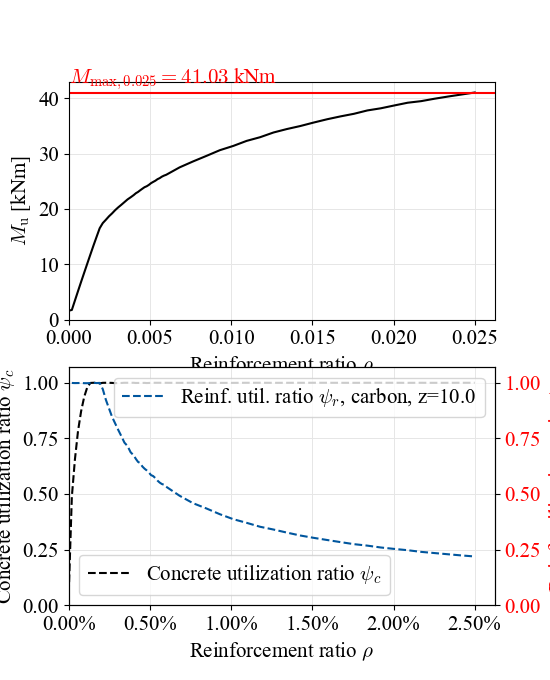

In [251]:
n_rho = 60
n_1 = int(0.35 * n_rho)
n_2 = int(0.25 * n_rho)
n_3 = n_rho - n_1 - n_2
rho_list = np.concatenate((np.linspace(0.0, 0.004, n_1, endpoint=False),
                           np.linspace(0.004, 0.006, n_2, endpoint=False),
                           np.linspace(0.006, 0.025, n_3)))

fig4, axes = mc.plot_M_rho_and_util_factors(type='stress', n_rho = n_rho, rho_list=rho_list)
ax1, ax2 = axes
fig4.show()

In [261]:
f_cms

array([ 20.        ,  29.77777778,  39.55555556,  49.33333333,
        59.11111111,  68.88888889,  78.66666667,  88.44444444,
        98.22222222, 108.        ])

In [45]:
AnaFRPBending(A_f=226.195, f_fu=1353.0, E_f=63252.0, f_cm=59.8, b=140.0, d=156.0).M_u

25.886888298733428

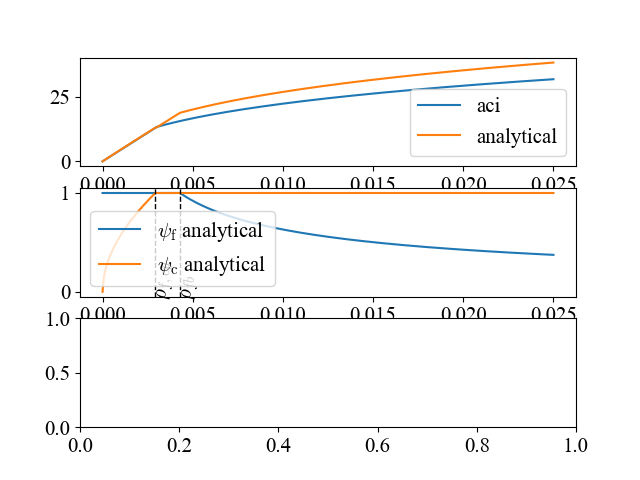

In [51]:
# bend = AnaFRPBending(f_cm = 90, E_f = 230000, f_fu = 1500)
# bend = AnaFRPBending(f_cm = 90, E_f = 247468.92, f_fu = 3823.9, b=300, d=90)
bend = AnaFRPBending(A_f=226.195, f_fu=1353.0, E_f=63252.0, f_cm=59.8, b=140.0, d=156.0)
# bend = AnaFRPBending(mc=mc)

rho_f_list = np.linspace(0, 0.025, 300)
psi_f_list = np.zeros_like(rho_f_list)
psi_c_list = np.zeros_like(rho_f_list)
M_u_list = np.zeros_like(rho_f_list)
M_u_aci_list = np.zeros_like(rho_f_list)
f_cms = np.linspace(20, 108, 10)

rho_diff = np.zeros_like(f_cms)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

for j, f_cm_ in enumerate([bend.f_cm]):
    bend.f_cm = f_cm_

    rho_diff[j] = bend.rho_fb - bend.rho_f_cy
    for i, rho_f in enumerate(rho_f_list):
        A_f = rho_f * bend.b * bend.d
        bend.A_f = A_f
        psi_f_list[i] = bend.psi_f
        psi_c_list[i] = bend.psi_c
        M_u_list[i] = bend.M_u
        M_u_aci_list[i] = ACI440.get_M_n(A_f=bend.A_f, f_fu=bend.f_fu, E_f=bend.E_f, f_c=bend.f_cm, b=bend.b, d=bend.d)

    ax1.plot(rho_f_list, M_u_aci_list, label = 'aci')
    ax1.plot(rho_f_list, M_u_list, label = 'analytical')
    ax1.legend()
    
    ax2.plot(rho_f_list, psi_f_list, label = r'$\psi_\mathrm{f}$ analytical')
    ax2.plot(rho_f_list, psi_c_list, label = r'$\psi_\mathrm{c}$ analytical')
    ax2.axvline(bend.rho_f_cy , ls='--', lw=1, c='black')
    ax2.axvline(bend.rho_fb , ls='--', lw=1, c='black')
    ax2.text(bend.rho_f_cy, 0, r'$\rho_{f, cy}$', rotation=90)
    ax2.text(bend.rho_fb, 0, r'$\rho_{fb}$', rotation=90)
    ax2.legend()

# ax3.plot(f_cms, rho_diff)
# fig

In [253]:
fig4.show()

In [255]:
# fig4.savefig('util_ratios_Mu_ACI_zoomed.pdf')